# Atividade prática 04

* Base de Dados Dogs and Cats:  
* Link Kaggle:  
https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification

* Construir uma CNN avaliando a configuração com diferentes camadas:   
i) Camada Convolucional com 128, 64 e 32 filtros  
ii) Tamanho do Kernel (3,3) e (5,5)  
iii) Pooling entre (2,2) e (4,4)  
iv) Variação do dropout entre as camadas (encontrar a porcentagem ideal)  
v) Testar com 1 e 2 camadas densas  
  
- Apresentar qual configuração apresentou o melhor desempenho   

## Encontrando todas as combinações possíveis dos parâmetros

In [1]:
parameters_list = {
    'p1': [128, 64, 32],                 # Filtros na primeira camada
    'p2': [3, 5],                        # Kernel Size (x,x)
    'p3': [2, 3, 4],                     # Pooling Size (x,x)
    'p4': [True, False],                 # Pré-camada densa
    'p5': [0.05, 0.1, 0.15, 0.2, 0.25]   # Dropout
}

In [4]:
from itertools import product

def encontrar_combinacoes(dicionario):
    chaves = dicionario.keys()
    valores = [dicionario[chave] for chave in chaves]
    todas_combinacoes = list(product(*valores))
    return todas_combinacoes

In [6]:
lista_parametros = encontrar_combinacoes(parameters_list)

## Importação das bibliotecas & Preparação da base

In [7]:
import opendatasets as od
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image

import matplotlib.pyplot as plt
import time

In [8]:
owner_user = 'samuelcortinhas'
project_name = 'cats-and-dogs-image-classification'

if not os.path.isdir(f'{project_name}/'):
    od.download(f'https://www.kaggle.com/datasets/{owner_user}/{project_name}')

In [11]:
img_size = 300 # tamanho da imagem - definido arbitariamente
batch_size = 64

# transformar dados da imagem em float
objTrain = ImageDataGenerator(rescale = 1./255)
dados_train = objTrain.flow_from_directory(project_name+'/train',
                                           target_size = (img_size, img_size),
                                           batch_size = batch_size,
                                           class_mode = 'categorical')


Found 557 images belonging to 2 classes.


In [12]:
objTest = ImageDataGenerator(rescale = 1./255)
dados_test = objTest.flow_from_directory(project_name+'/test',
                                         target_size = (img_size, img_size),
                                         batch_size = batch_size,
                                         class_mode = 'categorical')

Found 140 images belonging to 2 classes.


## Gerando todas as CNNs possíveis com os parâmetros indicados

In [13]:
# param = lista_parametros[4]
parametros_saida = []
epochs_train = 50
for param in lista_parametros:
    conv_filters = param[0]
    kernel_size = param[1]
    pooling_size = param[2]
    dense_units_1st = 32
    dense_units_2nd = 2
    fst_dense = param[3]
    dropout_pct = param[4]
    inicio = time.time()
    cnn = Sequential()
    cnn.add(Conv2D(conv_filters, (kernel_size, kernel_size), input_shape = (img_size, img_size, 3), activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size = (pooling_size, pooling_size)))
    cnn.add(Flatten())
    if fst_dense:
        cnn.add(Dense(units = dense_units_1st, activation = 'relu'))
    cnn.add(Dropout(dropout_pct))
    cnn.add(Dense(units = dense_units_2nd, activation = 'softmax'))
    cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    saida = cnn.fit(dados_train, verbose=0, steps_per_epoch =  len(dados_train.classes)//batch_size,  epochs = epochs_train, validation_data = dados_test, validation_steps = len(dados_test.classes)//batch_size)
    parametros_saida.append([time.time()-inicio, saida.history['accuracy'][-1], saida.history['val_accuracy'][-1]])
    print(param)
    print(time.time() - inicio)
    print(f"Acc com dados treino = {saida.history['accuracy'][-1]}")
    print(f"Acc com dados teste  = {saida.history['val_accuracy'][-1]}")
    print(f"Prob. de Overfitting = {saida.history['accuracy'][-1]/saida.history['val_accuracy'][-1]:.2f}")

(128, 3, 2, True, 0.05)
1443.479333639145
Acc com dados treino = 1.0
Acc com dados teste  = 0.5703125
Prob. de Overfitting = 1.75
(128, 3, 2, True, 0.1)
1386.015472650528
Acc com dados treino = 0.9979715943336487
Acc com dados teste  = 0.6015625
Prob. de Overfitting = 1.66
(128, 3, 2, True, 0.15)
1388.3480620384216
Acc com dados treino = 1.0
Acc com dados teste  = 0.5625
Prob. de Overfitting = 1.78
(128, 3, 2, True, 0.2)
1354.3739535808563
Acc com dados treino = 0.4929006099700928
Acc com dados teste  = 0.5078125
Prob. de Overfitting = 0.97
(128, 3, 2, True, 0.25)
1350.3515548706055
Acc com dados treino = 1.0
Acc com dados teste  = 0.5859375
Prob. de Overfitting = 1.71
(128, 3, 2, False, 0.05)
1415.7633888721466
Acc com dados treino = 1.0
Acc com dados teste  = 0.625
Prob. de Overfitting = 1.60
(128, 3, 2, False, 0.1)
1415.1513042449951
Acc com dados treino = 1.0
Acc com dados teste  = 0.578125
Prob. de Overfitting = 1.73
(128, 3, 2, False, 0.15)
1430.845043182373
Acc com dados treino 

In [16]:
np.savetxt("saida.csv",
        parametros_saida,
        delimiter =", ",
        fmt ='% s')
np.savetxt("entradas.csv",
        lista_parametros,
        delimiter =", ",
        fmt ='% s')

## Avaliando os resultados

In [17]:
import pandas as pd

In [25]:
data_in = pd.read_csv('entradas.csv', header=None, names= ['filters', 'kernel', 'pooling', '1st_dense', 'dropout'])
data_out = pd.read_csv('saida.csv', header=None, names= ['time_sec', 'acc_train', 'acc_test'])
data = pd.concat([data_in, data_out], axis=1)

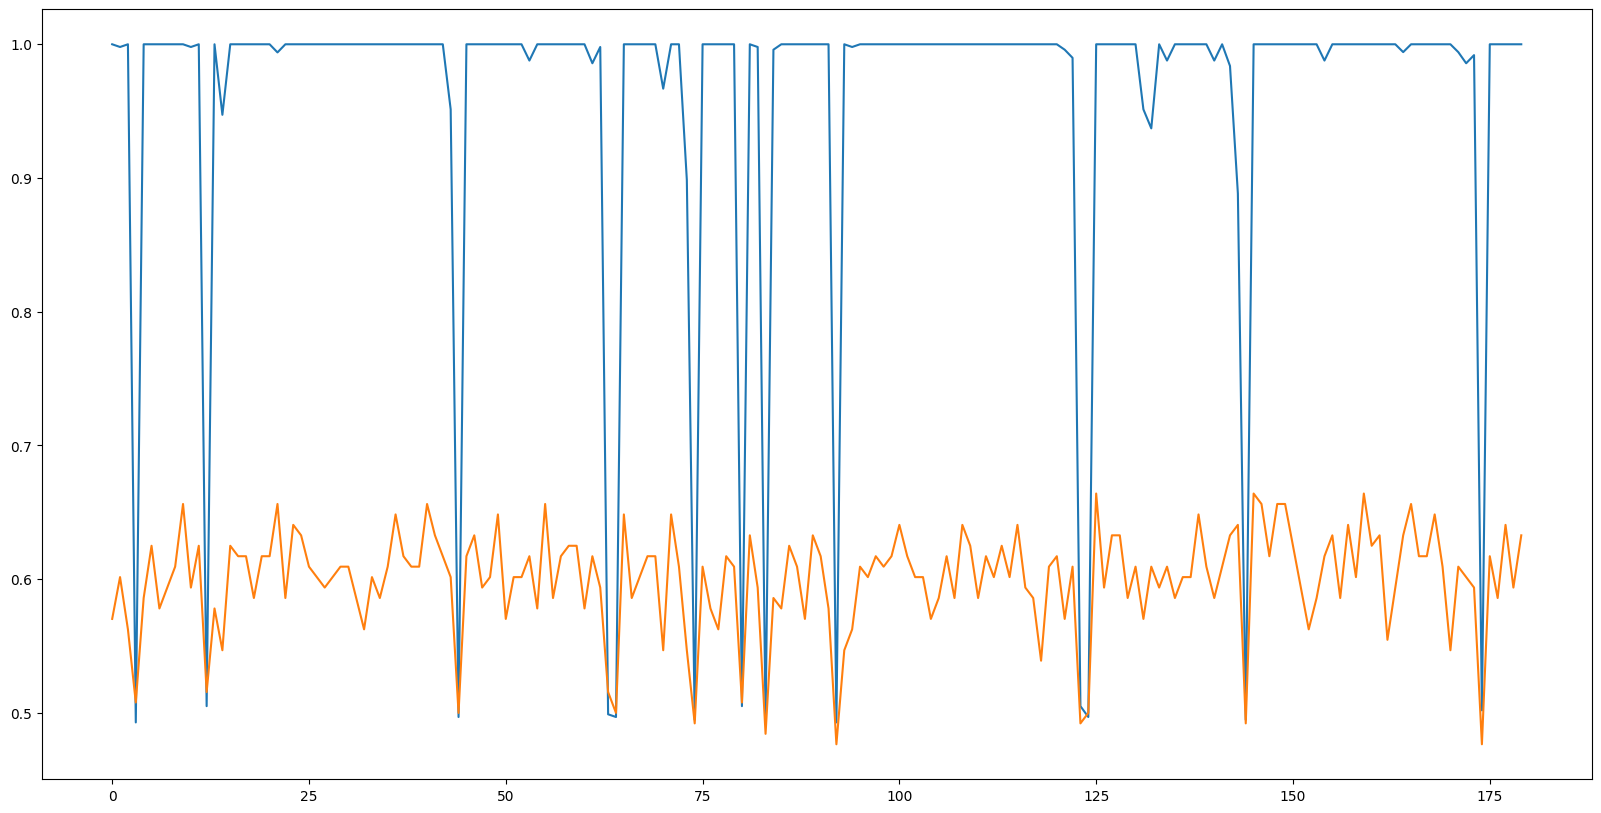

In [36]:
plt.figure(figsize=(20,10))
plt.plot(data.index, data['acc_train'])
plt.plot(data.index, data['acc_test'])
plt.show()

Cada coluna do dataframe contém as informações usadas para gerar a CNN, bem como os resultados. 

In [28]:
data.sort_values(['acc_test', 'acc_train', 'time_sec'], ascending=[False, False, True])

,filters,kernel,pooling,1st_dense,dropout,time_sec,acc_train,acc_test
145,32.0,3.0,4.0,0.0,0.05,335.417464,1.000000,0.664062
125,32.0,3.0,2.0,0.0,0.05,447.403144,1.000000,0.664062
159,32.0,5.0,2.0,0.0,0.25,606.341931,1.000000,0.664062
149,32.0,3.0,4.0,0.0,0.25,330.612358,1.000000,0.656250
148,32.0,3.0,4.0,0.0,0.20,331.683913,1.000000,0.656250
...,...,...,...,...,...,...,...,...
144,32.0,3.0,4.0,1.0,0.25,327.046181,0.494929,0.492188
74,64.0,3.0,3.0,1.0,0.25,654.999478,0.494929,0.492188
83,64.0,3.0,4.0,1.0,0.20,616.340098,0.492901,0.484375
174,32.0,5.0,4.0,1.0,0.25,553.889232,0.501953,0.476562


Portanto, podemos indicar que a configuraçãoi abaixo possui o melhor desempenho:   
i) Camada Convolucional com  e 32 filtros  
ii) Tamanho do Kernel (3,3)  
iii) Pooling (2,2) e (4,4) (mesmo desempenho)  
iv) Dropout de 5%  
v) 1 densa apenas  

Essa configuração nos dá uma acuracidade de 66,40% nas imagens de teste.  
Porém, nenhuma das configurações indicadas apresenta um bom resultado, quando olhamos para a acuracidade na base teste.  
Quando olhamos para a base treino, a acuracidade de quase todas as configurações é bastante elevada, indicando que a rede criada possui um overfitting, ou seja, tem uma capacidade de generalização reduzida.  
Para solucionar tal problema, seria indicado trabalhar com técnicas de image augmentation, ou geração de imagens com ruídos aleatórios na entrada do modelo.  
